In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [5]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras import metrics

from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D

In [6]:
final_df = pd.read_csv('./consolidated_4_10pct_sample.csv')
final_df.shape

(1169778, 163)

In [7]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, test_ids

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [9]:
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [10]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    https://stackoverflow.com/questions/43178668/
    record-the-computation-time-for-each-epoch-in-keras-during-model-fit
    """

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
def mlp_model(layers, units, dropout_rate, input_shape, op_units, op_activation):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
      layers: int, number of `Dense` layers in the model.
      units: int, output dimension of the layers.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      input_shape: tuple, shape of input to the model.
      op_units: number of output units (1 for binary target)
      op_activation: activation function (sigmoid for binary target)

    Returns
      An MLP model instance.
    """

    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers - 1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))

    return model

In [12]:
def train_model(data,
                model_type='cnn',
                learning_rate=1e-3,
                epochs=1000,
                batch_size=128,
                blocks=2,
                filters=64,
                layers=2,
                units=64,
                dropout_rate=0.2,
                kernel_size=3,
                pool_size=3,
                num_classes=2,
                class_weights={0:1.,1:1.}):
    """
    Trains sequence model on the given dataset.

    Args:
      data: tuples of vectorized training and test texts and labels.
      log_dir: directory to write logs to

    Kwargs:
      model_type: str, type of model to train
      word_index: word_index if applicable
      learning_rate: float, learning rate for training model.
      epochs: int, number of epochs.
      batch_size: int, number of samples per batch.
      blocks: int, number of pairs of sepCNN and pooling blocks in the model.
      filters: int, output dimension of sepCNN layers in the model.
      dropout_rate: float: percentage of input to drop at Dropout layers.
      embedding_dim: int, dimension of the embedding vectors.
      kernel_size: int, length of the convolution window.
      pool_size: int, factor by which to downscale input at MaxPooling layer.
      max_num_words: int, max number of features to use
      num_classes: int, number of classes in the target variable
      use_pretrained_embedding: bool, use pretrained embeddings or no
      is_embedding_trainable: bool, train embeddings or no
      use_word_embedding: bool, False if sentence encodding is used
      glove_dir: directory with glove embeddings if applicable
    """

    # Get the data.
    x_train, train_labels, x_val, val_labels = data

    if num_classes == 2:
        op_units, op_activation = 1, 'sigmoid'
    else:
        op_units, op_activation = num_classes, 'softmax'

    # Create model instance.
    if model_type == 'cnn':
        model = cnn_model(filters=filters,
                          kernel_size=kernel_size,
                          layers=layers,
                          dropout_rate=dropout_rate,
                          pool_size=pool_size,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)
    elif model_type == 'mlp':
        model = mlp_model(layers=layers,
                          units=units,
                          dropout_rate=dropout_rate,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
#     optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate) - didn't work (too many false negatives)
#     optimizer = tf.keras.optimizers.SGD(lr=learning_rate) - similar performance to Adam
#     optimizer = tf.keras.optimizers.Adagrad(lr=learning_rate) - didn't work (too many false positives)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[metrics.Recall()])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
#           tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=2),
          TimeHistory()]

    # Train and validate model.
    history = model.fit(
      x_train,
      train_labels,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=(x_val, val_labels),
      verbose=2,  # Logs once per epoch.
      batch_size=batch_size,
      class_weight=class_weights)

    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history.history, model, train_pred_probs, val_pred_probs

In [13]:
scaler = MinMaxScaler()

## Optimizer: Adam; Features: - precipitation

In [14]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
#  'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
#  'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
#  'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
#  'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [26]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features
train, test, y_train, y_test, test_ids = split_train_test(final_df, feature_cols)

In [27]:
train.shape, test.shape

((780816, 33), (388962, 33))

In [17]:
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cw

array([  0.50156157, 160.59563965])

In [28]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
model_params = {
    'model_type': 'mlp',
    'learning_rate': 1e-3,
    'epochs': 20,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2,
    'class_weights': {0: 1., 1: 2000.}
}

In [30]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train, test_sc, y_test), **model_params)

Train on 780816 samples, validate on 388962 samples
Epoch 1/20
 - 9s - loss: 0.5663 - recall_1: 0.1172 - val_loss: 0.3803 - val_recall_1: 0.1562
Epoch 2/20
 - 9s - loss: 0.5529 - recall_1: 0.2049 - val_loss: 0.4720 - val_recall_1: 0.5056
Epoch 3/20
 - 10s - loss: 0.5471 - recall_1: 0.2501 - val_loss: 0.4400 - val_recall_1: 0.3535
Epoch 4/20
 - 10s - loss: 0.5400 - recall_1: 0.2653 - val_loss: 0.4190 - val_recall_1: 0.3205
Epoch 5/20
 - 9s - loss: 0.5374 - recall_1: 0.3406 - val_loss: 0.4756 - val_recall_1: 0.5531
Epoch 6/20
 - 9s - loss: 0.5363 - recall_1: 0.3007 - val_loss: 0.4843 - val_recall_1: 0.6055
Epoch 7/20
 - 9s - loss: 0.5304 - recall_1: 0.3270 - val_loss: 0.4926 - val_recall_1: 0.6707
Epoch 8/20
 - 9s - loss: 0.5328 - recall_1: 0.3427 - val_loss: 0.4446 - val_recall_1: 0.5556
Epoch 9/20
 - 9s - loss: 0.5320 - recall_1: 0.3414 - val_loss: 0.3995 - val_recall_1: 0.3671
Epoch 10/20
 - 9s - loss: 0.5316 - recall_1: 0.3311 - val_loss: 0.4812 - val_recall_1: 0.6248
Epoch 11/20
 - 

In [36]:
model_mlp.save('./Models/mlp_adam_noprecip_cw2000.h5')

In [56]:
model_mlp

In [31]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000000    0.0   21975  0.043555
2    0.000237    8.0   33768  0.155113
3    0.000266   14.0   52631  0.251570
4    0.000782   48.0   61379  0.351754
5    0.003214  296.0   92110  0.455343
6    0.006379  744.0  116631  0.540164
7    0.013222  128.0    9681  0.633043
8    0.005229    4.0     765  0.726134
9    0.000000    0.0       5  0.819805
10   0.000000    0.0      17  0.994023

In [34]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

127099

Confusion matrix, without normalization
[[261497 126223]
 [   366    876]]
              precision    recall  f1-score   support

         nwf       1.00      0.67      0.81    387720
          wf       0.01      0.71      0.01      1242

   micro avg       0.67      0.67      0.67    388962
   macro avg       0.50      0.69      0.41    388962
weighted avg       1.00      0.67      0.80    388962



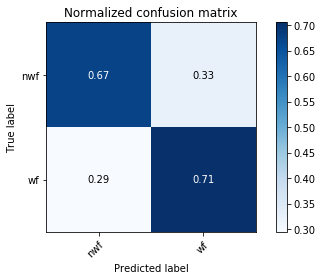

In [35]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

## Optimizer: Adam; Features: + precipitation

In [43]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
 'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [44]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features
train, test, y_train, y_test, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [46]:
model_params = {
    'model_type': 'mlp',
    'learning_rate': 0.001,
    'epochs': 20,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2,
    'class_weights': {0: 1., 1: 2000.}
}

In [47]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train, test_sc, y_test), **model_params)

Train on 780816 samples, validate on 388962 samples
Epoch 1/20
 - 11s - loss: 0.5622 - recall_3: 0.1547 - val_loss: 0.5223 - val_recall_3: 0.6232
Epoch 2/20
 - 10s - loss: 0.5461 - recall_3: 0.1929 - val_loss: 0.4177 - val_recall_3: 0.3253
Epoch 3/20
 - 10s - loss: 0.5458 - recall_3: 0.2480 - val_loss: 0.2950 - val_recall_3: 0.0298
Epoch 4/20
 - 9s - loss: 0.5387 - recall_3: 0.2912 - val_loss: 0.4209 - val_recall_3: 0.3849
Epoch 5/20
 - 9s - loss: 0.5379 - recall_3: 0.2995 - val_loss: 0.5510 - val_recall_3: 0.7641
Epoch 6/20
 - 9s - loss: 0.5356 - recall_3: 0.3348 - val_loss: 0.4847 - val_recall_3: 0.6135
Epoch 7/20
 - 10s - loss: 0.5308 - recall_3: 0.3287 - val_loss: 0.4944 - val_recall_3: 0.6610
Epoch 8/20
 - 10s - loss: 0.5288 - recall_3: 0.3616 - val_loss: 0.4465 - val_recall_3: 0.4750
Epoch 9/20
 - 10s - loss: 0.5237 - recall_3: 0.3497 - val_loss: 0.4704 - val_recall_3: 0.5725
Epoch 10/20
 - 10s - loss: 0.5249 - recall_3: 0.3575 - val_loss: 0.5370 - val_recall_3: 0.7770
Epoch 11/2

In [51]:
model_mlp.save('./Models/mlp_adam_precip_cw2000.h5')

In [48]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000188    5.0   26585  0.046102
2    0.000205    8.0   38968  0.155045
3    0.000305   16.0   52543  0.251285
4    0.001126   71.0   63031  0.352163
5    0.002665  243.0   91175  0.453981
6    0.007460  797.0  106839  0.542620
7    0.011011   94.0    8537  0.629201
8    0.009485    7.0     738  0.730117
9    0.008197    1.0     122  0.852240
10   0.000000    0.0     334  0.971275
11   0.000000    0.0      90  1.000000

In [49]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

116660

Confusion matrix, without normalization
[[271959 115761]
 [   343    899]]
              precision    recall  f1-score   support

         nwf       1.00      0.70      0.82    387720
          wf       0.01      0.72      0.02      1242

   micro avg       0.70      0.70      0.70    388962
   macro avg       0.50      0.71      0.42    388962
weighted avg       1.00      0.70      0.82    388962



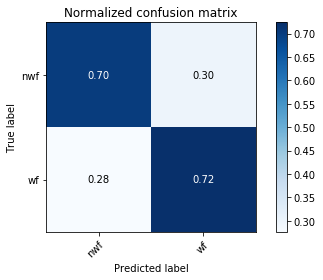

In [50]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)